<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2024/blob/main/tutorial/Tutorial_06_Tuning_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dr. Daugherity, PHYS 453

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Tutorial 6 - Tuning and Evaluation


We've already discussed some binary classification metrics in class and have played with evaluating mystery classifiers using the built-in reports:
* User's Guide: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
* Classification Report: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
* [Classifier Challenge](https://github.com/mdaugherity/MachineLearning2022/blob/main/Class/Class_1_28_2022_Classifier_Challenge.ipynb)

Now we make this approach more official and see how to properly tune and evaluate classifiers.  Remember, the goal is to finish the overview of classification problems before we dive in to seeing how more classifiers actually work.



# Test/Train Split
To meet our goal of making the "best" classifier we have to answer two closely related questions:
1.  How do we choose the best parameters to avoid under/over-fitting?
1.  How well will our classifier do with *new* samples?  

The answer to both is to split the dataset and save a fraction as our "test" data that we **DO NOT FIT THE CLASSIFIER** with.  

<img src='https://scikit-learn.org/stable/_images/grid_search_workflow.png' width=500>

The concept of saving data where we know the right answer is our key to tuning parameters and estimating performance.  Data that has been used to train the classifier **cannot** be use to fairly evaluate a classifier.

We will do this twice:
* Data used for tuning the best parameters is usually called **VALIDATION DATA**.  We will use a cool trick called cross-validation to use all of the data efficiently.
* After all of the choices are made and everything is done, only then will we use the **TEST DATA** to estimate the final performance of the classifier on new data.

**References**
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
* https://scikit-learn.org/stable/modules/cross_validation.html  (figure source)

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

## Random State
Before we begin, it is important to understand how ```random_state``` works.  In a nutshell, there is no such thing as a random number in computing.  All random numbers are generated from a seed, and the same algorithm with the same seed produces the same list of numbers.  It is sometimes convenient to get set the seed with ```random_state``` to get the same results while you are working.  Common values are 0,1, 42, or other sci-fi / pop-culture references.  

A good analogy is to think about a book filled with numbers.  Setting random_state tells the program which page of the book to use.  

For more detail, read section 10.3 in https://scikit-learn.org/stable/common_pitfalls.html

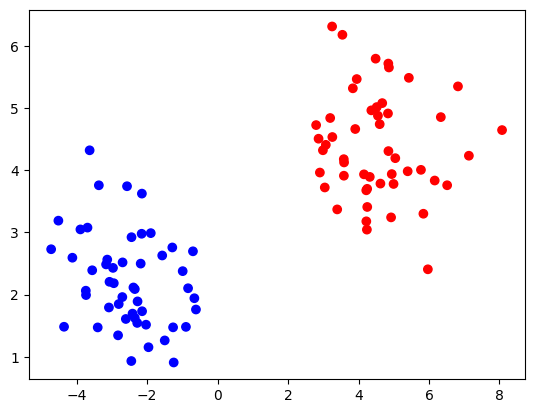

In [3]:
# Run this with and without random_state
#X,y = make_blobs(centers=2, random_state=0)
X,y = make_blobs(centers=2)

plt.scatter(X[:,0], X[:,1],c=y,cmap='bwr')
plt.show()

(100,) (80,) (20,)


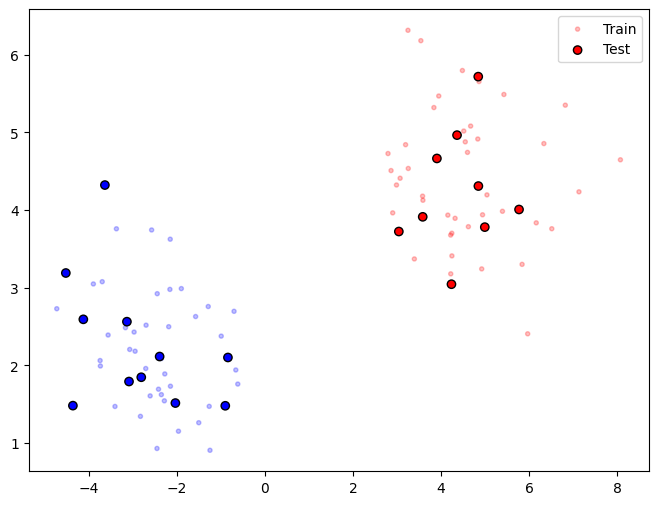

In [4]:
# Run this with and without random_state
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(y.shape, y_train.shape, y_test.shape)

plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0], X_train[:,1],marker='.',c=y_train,cmap='bwr',label='Train', alpha=0.25)
plt.scatter(X_test[:,0], X_test[:,1],marker='o',edgecolor='k',c=y_test,cmap='bwr',label='Test')
plt.legend()

plt.show()

# Choosing the right values (tuning parameters)
Essentially all classifiers have parameters you can tune to improve performance.  For example, how do we choose k for kNearestNeighbors?

In [5]:
from sklearn import datasets
from sklearn import neighbors
from sklearn import model_selection

In [6]:
#data = datasets.load_iris()
data = datasets.load_breast_cancer()
print('Features:\t',data.feature_names)
print('Targets:\t',data.target_names)

X = data.data
y = data.target

Features:	 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Targets:	 ['malignant' 'benign']


In [7]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5)   # how many to pick?

# HARD MODE: Manual Brute Force
We'll start by doing things the hard way for transparency.  The basic approach is:
1.  Split the data into testing and training sets
1.  Call ```fit``` on training data
1.  Score the classifier on the testing data
1.  Use brutal force to try lots of options and pick the best one

Play with this code below.  Notice how the results depend on test_size and can be VERY sensitive on random_state.


(569, 30)
Best k: 1
Best Test Score: 0.9298245614035088


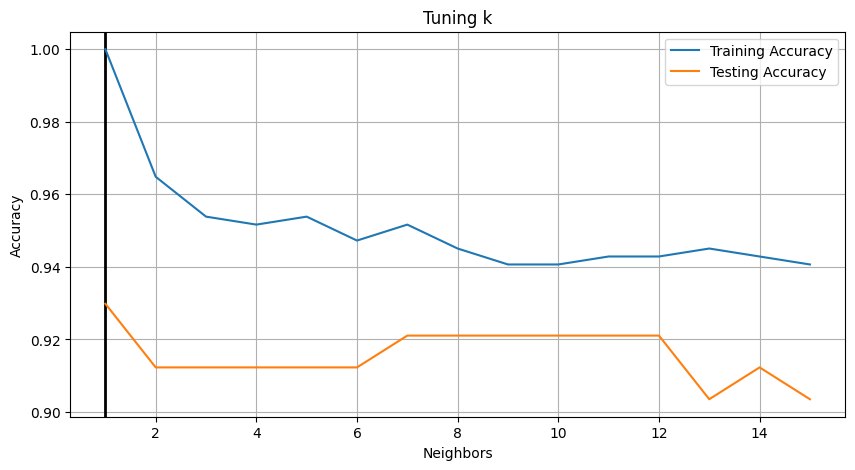

In [8]:
# Run this with and without random_state
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)#random_state=1)
print(X.shape)

KLIST = np.arange(1,16)

# DOING THIS THE HARD WAY--don't use this method
# Manually check lots of values of k to find the best test score
train_scores = np.zeros_like(KLIST,dtype=float)  # don't want INTs here!
test_scores =  np.zeros_like(KLIST,dtype=float)
for i,k in enumerate(KLIST):
  clf = neighbors.KNeighborsClassifier(n_neighbors=k)
  clf.fit(X_train,y_train)
  test_scores[i] = clf.score(X_test,y_test)
  train_scores[i] = clf.score(X_train,y_train)

best_k = KLIST[test_scores.argmax()]
print(f"Best k: {best_k}")
print(f"Best Test Score: {test_scores.max()}")

plt.figure(figsize=(10,5))
plt.axvline(best_k, color='black', lw=2) # draw black line behind best params
plt.plot(KLIST, train_scores, label='Training Accuracy')
plt.plot(KLIST, test_scores, label='Testing Accuracy')
plt.legend()
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.title('Tuning k')
plt.grid()
plt.show()

# EASY MODE: Cross Valildation Grid Search

A great way to get more consistent results is to use **cross validation**.  We do the process 5 times and average over the results to ensure that the entire training data set gets used.

As always, we DO NOT PEEK at the test data until we have completely finalized our classifier.

<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' width=500>

In this example below, we'll see how cross validation gives more stable results than the previous example.

**References:**
* https://scikit-learn.org/stable/modules/cross_validation.html#multimetric-cross-validation
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV





In [9]:
# Quick demo: see how cross_val_score returns a score for each "fold"
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train,y_train)
model_selection.cross_val_score(clf,X_train,y_train)

array([0.96703297, 0.86813187, 0.94505495, 0.96703297, 0.95604396])

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)  #random_state=1)

# Automatically search for the best parameters
KLIST = np.arange(1,16)
params = {'n_neighbors':KLIST, 'weights':['uniform','distance']}  # Set up parameters to try
print('Parameters to try:',params)

grid_clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid=params, return_train_score=True)
grid_clf.fit(X,y)

print('Best estimator:', grid_clf.best_estimator_)
print('Best parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)

Parameters to try: {'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'weights': ['uniform', 'distance']}
Best estimator: KNeighborsClassifier(n_neighbors=13)
Best parameters: {'n_neighbors': 13, 'weights': 'uniform'}
Best score: 0.9332401800962584


## Diving In
The above example shows how quick and easy it is to get a result using GridSearchCV.  Below are totally unnecesary examples of how to dive in to the search results and see what happened.

In [11]:
res = grid_clf.cv_results_
res.keys() # Wow, look at all of this

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [12]:
res

{'mean_fit_time': array([0.00158682, 0.00084424, 0.00091033, 0.00093246, 0.00095491,
        0.00178518, 0.00099664, 0.000878  , 0.00098777, 0.00082622,
        0.00094085, 0.00087609, 0.00093846, 0.00253544, 0.00090251,
        0.00625029, 0.00336776, 0.00458593, 0.00099349, 0.00229154,
        0.00243211, 0.00208406, 0.00086985, 0.00073566, 0.00088577,
        0.00151939, 0.00096049, 0.00094609, 0.00091634, 0.0007329 ]),
 'std_fit_time': array([1.16776840e-03, 1.03062591e-04, 1.16556345e-04, 1.43859092e-04,
        7.82373973e-05, 1.77153823e-03, 1.72284928e-04, 1.08322101e-04,
        1.13017851e-04, 1.27971634e-04, 2.69353489e-05, 1.10881773e-04,
        7.70106625e-05, 3.21872646e-03, 1.12631077e-04, 5.26670053e-03,
        1.89573155e-03, 6.03150721e-03, 4.65464880e-05, 2.84451419e-03,
        2.94390447e-03, 2.28178988e-03, 7.24725971e-05, 1.14788343e-04,
        1.03129681e-04, 1.53827708e-03, 4.26076348e-05, 1.62492811e-04,
        1.16285186e-04, 9.81076665e-05]),
 'mean_scor

## Helper Functions
Here's some code I wrote for visualizing the output of a grid search

In [13]:
def make_grid_plot_labels(grid_clf):
  # Turns a parameter dictionary entry into a single string.  Not elegant.
  res = grid_clf.cv_results_
  NUM_KEYS = len(res['params'][0].values())
  labels = []
  for item in res['params']:
    s = ""
    for val in item.values():
      s+= str(val)
      s+='_'
    labels.append(s[:-1])
  return labels

def make_grid_plot(grid_clf):
  # Displays the scores for every set of parameters
  res = grid_clf.cv_results_
  plt.figure(figsize=(8,4))
  plt.axvline(grid_clf.best_index_, color='black', lw=2) # draw black line behind best params
  plt.plot(res['mean_test_score'],'-o', label='Validaiton')
  plt.plot(res['mean_train_score'],'-s', label='Train')
  plt.title('Grid CV Results')
  plt.ylabel('Mean Test Score')
  NUM_KEYS = len(res['params'])
  labels = make_grid_plot_labels(grid_clf)
  plt.xticks(ticks = np.arange(NUM_KEYS), labels=labels, rotation=90)
  plt.legend()
  plt.grid()
  plt.show()

## GridCV With Plots

Parameters to try: {'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'weights': ['uniform', 'distance']}
Best estimator: KNeighborsClassifier(n_neighbors=13)
Best parameters: {'n_neighbors': 13, 'weights': 'uniform'}
Best score: 0.9332401800962584


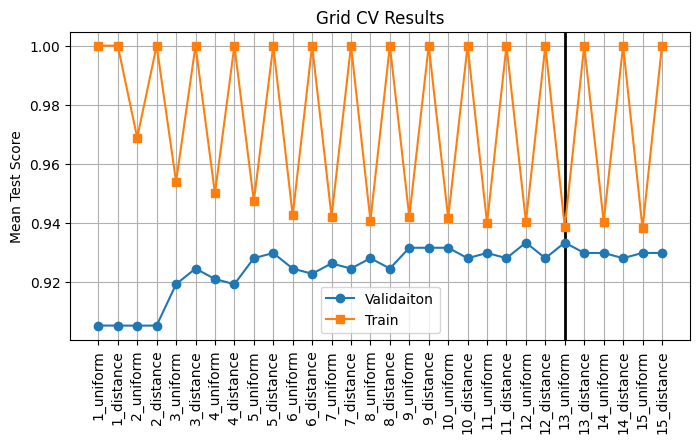

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)  #random_state=1)

# Automatically search for the best parameters
KLIST = np.arange(1,16)
params = {'n_neighbors':KLIST, 'weights':['uniform','distance']}  # Set up parameters to try
print('Parameters to try:',params)

grid_clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid=params, return_train_score=True)
grid_clf.fit(X,y)

print('Best estimator:', grid_clf.best_estimator_)
print('Best parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)

make_grid_plot(grid_clf)

# Conclusion
* Use a test/train split to evaulate your classifier.  
* Do a CV Grid Search on the training data to tune parameters